# Pool-based Active Learning for Regression - Getting Started

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-activeml/scikit-activeml.github.io/blob/gh-pages/development/generated/tutorials_colab//02_pool_regression_getting_started.ipynb)

**Notebook Dependencies**

Uncomment the following cells to install all dependencies for this tutorial.

In [1]:
# !pip install scikit-activeml

<hr style="border-style: solid; border-top: 1px solid; border-right: 0; border-bottom: 0; border-left: 0;">

This notebook compares a selection of query strategies in the field of regression.

In [1]:
import warnings

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from skactiveml.pool import GreedySamplingX, GreedySamplingTarget, QueryByCommittee, \
    KLDivergenceMaximization
from sklearn.ensemble import BaggingRegressor
from skactiveml.regressor import NICKernelRegressor, SklearnRegressor
from skactiveml.utils import call_func, is_labeled, MISSING_LABEL
from scipy.stats import norm, uniform

mlp.rcParams["figure.facecolor"] = "white"

## Data Set Generation
To do so, we first generate four different datasets to compare how each query strategies decides which sample should be labeled next.

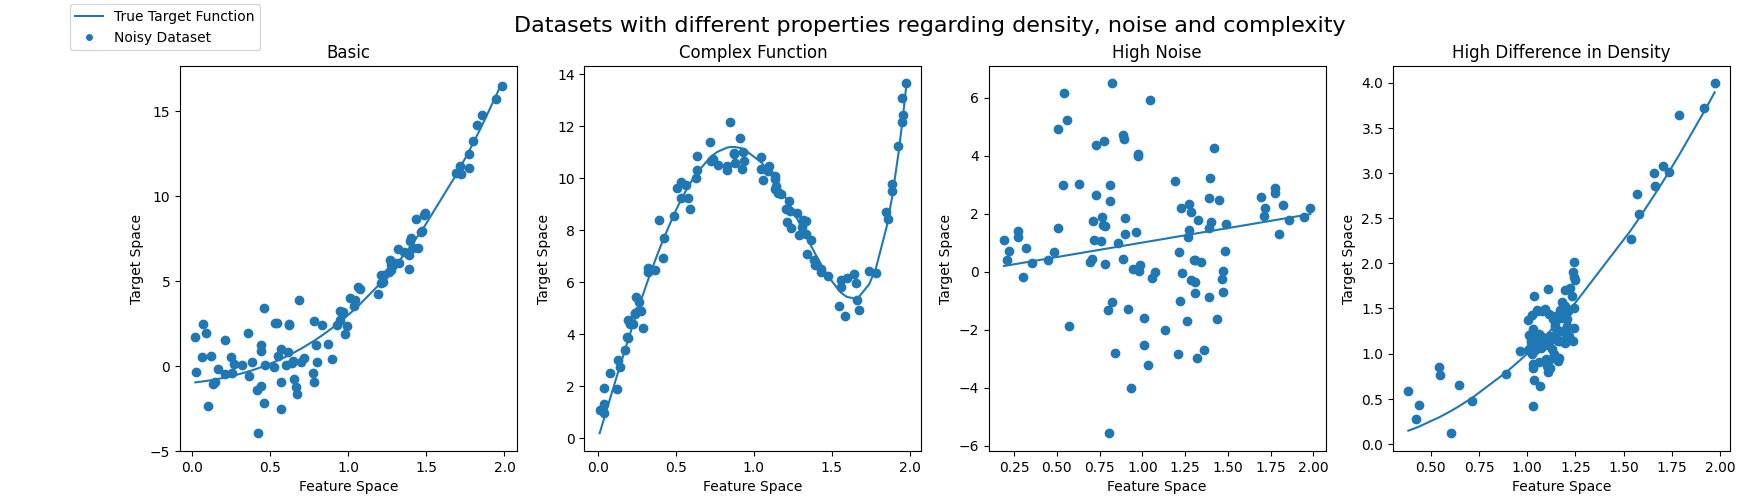

In [2]:
random_state = 0
n_iterations = 8

def uniform_rvs(*pos_args, **key_word_args):
    return uniform.rvs(*pos_args, **key_word_args, random_state=random_state)

def norm_rvs(*pos_args, **key_word_args):
    return norm.rvs(*pos_args, **key_word_args, random_state=random_state)

settings = {
    'Basic': (
        lambda X_: (X_**3 + 2*X_**2 + X_ - 1).flatten(),
        np.sort(np.concatenate((uniform_rvs(0, 1, 60),uniform_rvs(1, 0.5, 30), uniform_rvs(1.5, 0.5, 10)))),
        np.concatenate((norm_rvs(0, 1.5, 60), norm_rvs(0, 0.5, 40)))
    ),
    'Complex Function': (
        lambda X_: (6/7*X_**6 - 10*X_**3 + 20*X_).flatten(),
        np.sort(uniform_rvs(0, 2, 100)),
        norm_rvs(0, 0.5, 100)
    ),
    'High Noise': (
        lambda X_: X_.flatten(),
        np.sort(np.concatenate(tuple(uniform_rvs(s, 0.5, n) for s, n in [(0, 10), (0.5, 40), (1.0, 40), (1.5, 10)]))),
        np.concatenate(tuple(norm_rvs(0, std, n) for std, n in [(0.5, 10), (2.5, 80), (0.5, 10)]))
    ),
    'High Difference in Density': (
        lambda X_: (X_**2).flatten(),
        np.sort(np.concatenate((uniform_rvs(0, 1, 10), uniform_rvs(1, 0.25, 80), uniform_rvs(1.25, 0.75, 10)))),
        norm_rvs(0, 0.25, 100)
    )
}
fig, axes = plt.subplots(1, len(settings), figsize=(20, 5))
fig.suptitle("Datasets with different properties regarding density, noise and complexity", fontsize=16)
for (setting_name, setting), ax in zip(settings.items(), axes):
    true_function, X, noise = setting
    X = X.reshape(-1, 1)
    y_true = true_function(X) + noise
    X_test = np.linspace(0, 2, num=200).reshape(-1, 1)

    ax.set_title(setting_name)
    ax.scatter(X, y_true)
    ax.set_xlabel("Feature Space")
    ax.set_ylabel("Target Space")
    ax.plot(X, true_function(X))
legend_elements = [
        Line2D([0], [0], color='tab:blue',label='True Target Function'),
        Line2D([0], [0], marker='o', color='w',markerfacecolor='tab:blue', label='Noisy Dataset'),
    ]
fig.legend(handles=legend_elements, loc=(0.04, 0.9))
plt.show()

## Active Regression
Now, we want to look at how the different query strategies determine, which samples to query. We do so by looking at the utility assigned by each query strategy for querying a sample. The assigned utility is displayed by the lightgreen line matching the axis to the right. The unlabeled samples are lightblue, the already labeled samples are orange, and the sample selected to be queried next is red. The model predictions, built by the orange samples, are displayed in black. Here we first look at the `'Basic'` dataset. To view the query behavior for different datasets, set `setting_name` to be one of `['Basic', 'Complex Function', 'High Noise', 'High Difference in Density']`.

As a result, we make the following observations:
- `GreedySamplingX` queries labels quiet uniformly over the feature space creating utility spikes evenly between the labeled samples across the feature space.
- `GreedySamplingTarget` has a strong tendency to query labels where the target values are steep if the function is monotone, since there the target values differ the most from the prediction.
- `QueryByCommittee` only queries, where some target data is available, slowly gaining diversity. This happens because all the learners share the same prior and thus do not differ, where no target data exist.
- `KLDivergenceMaximization` seems to rely on the steepness of the target data the density and the variance, which seems to create a quiet uniform querying density.

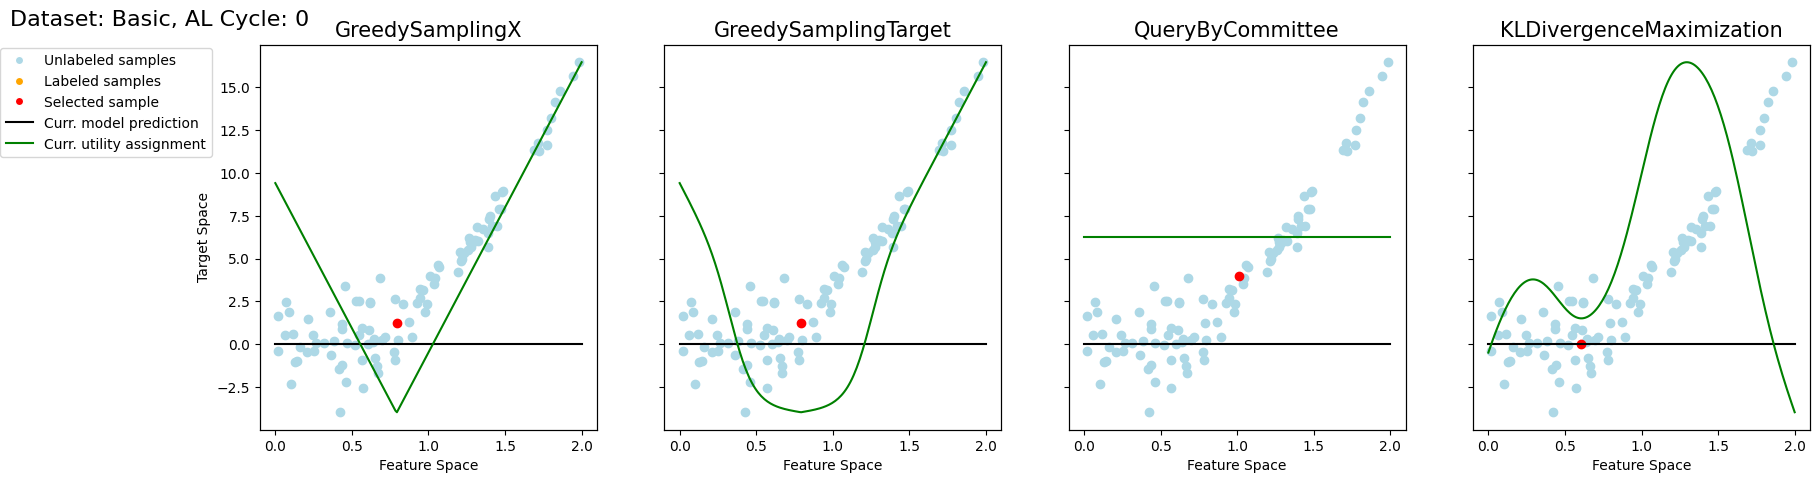

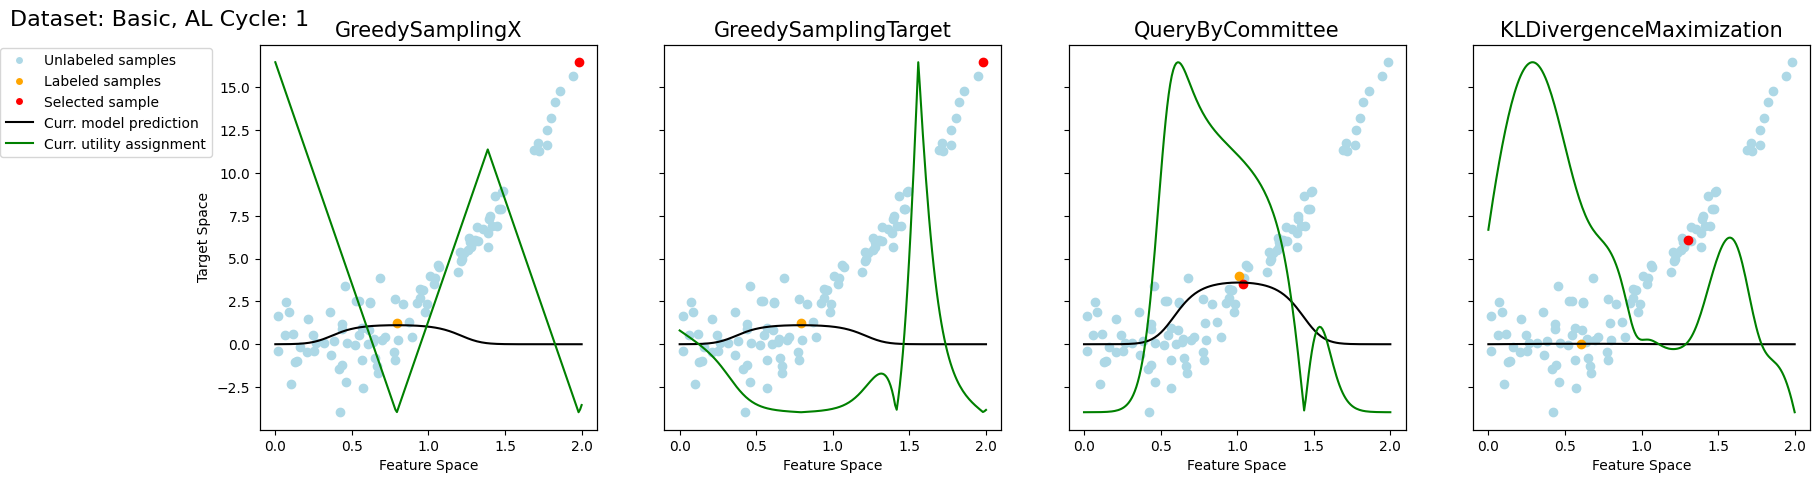

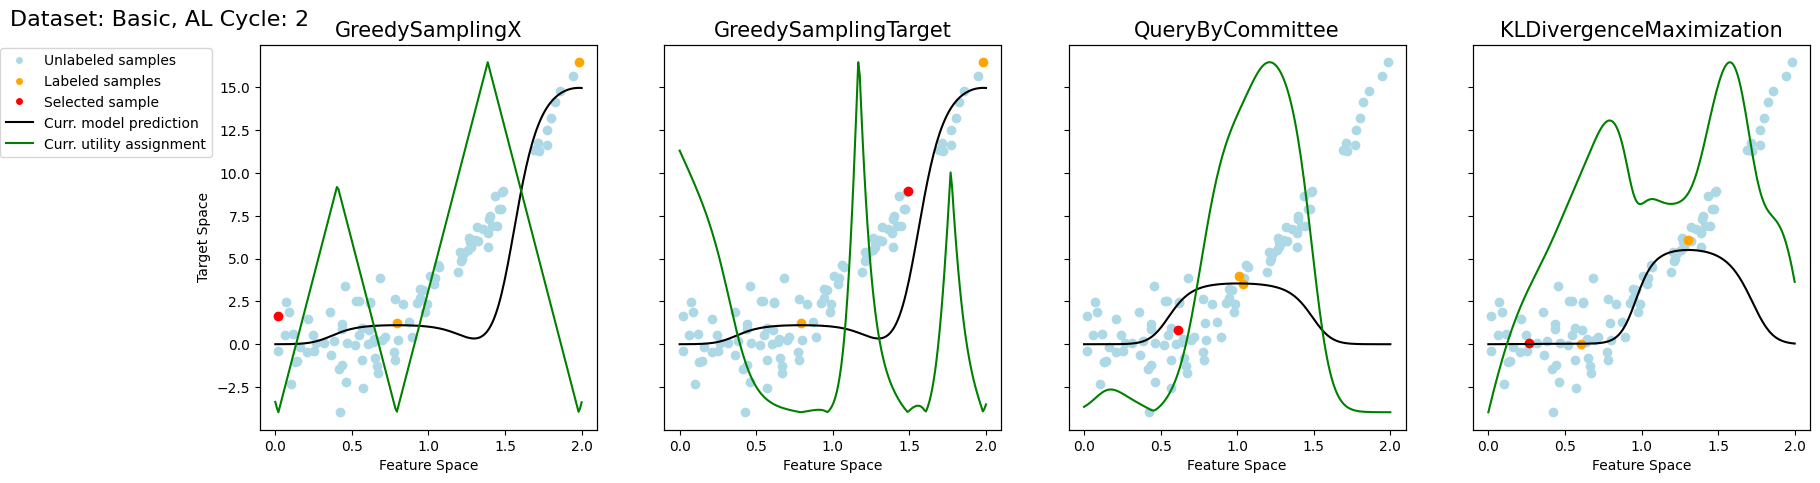

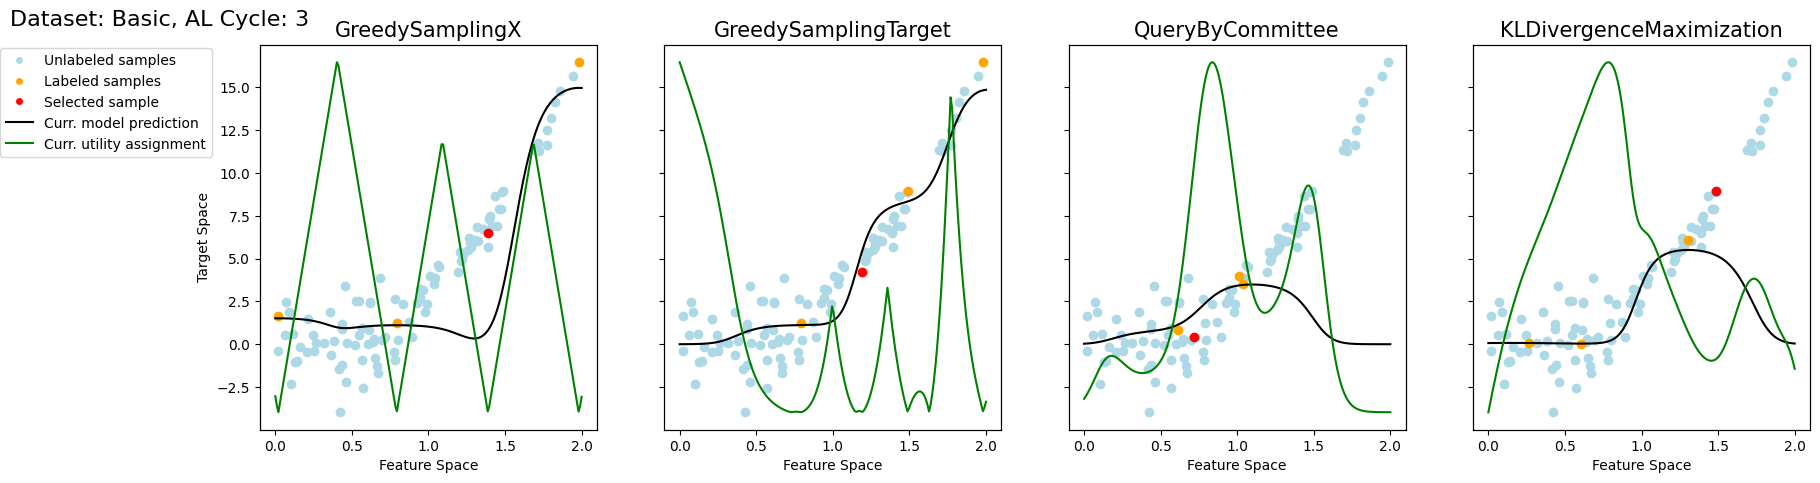

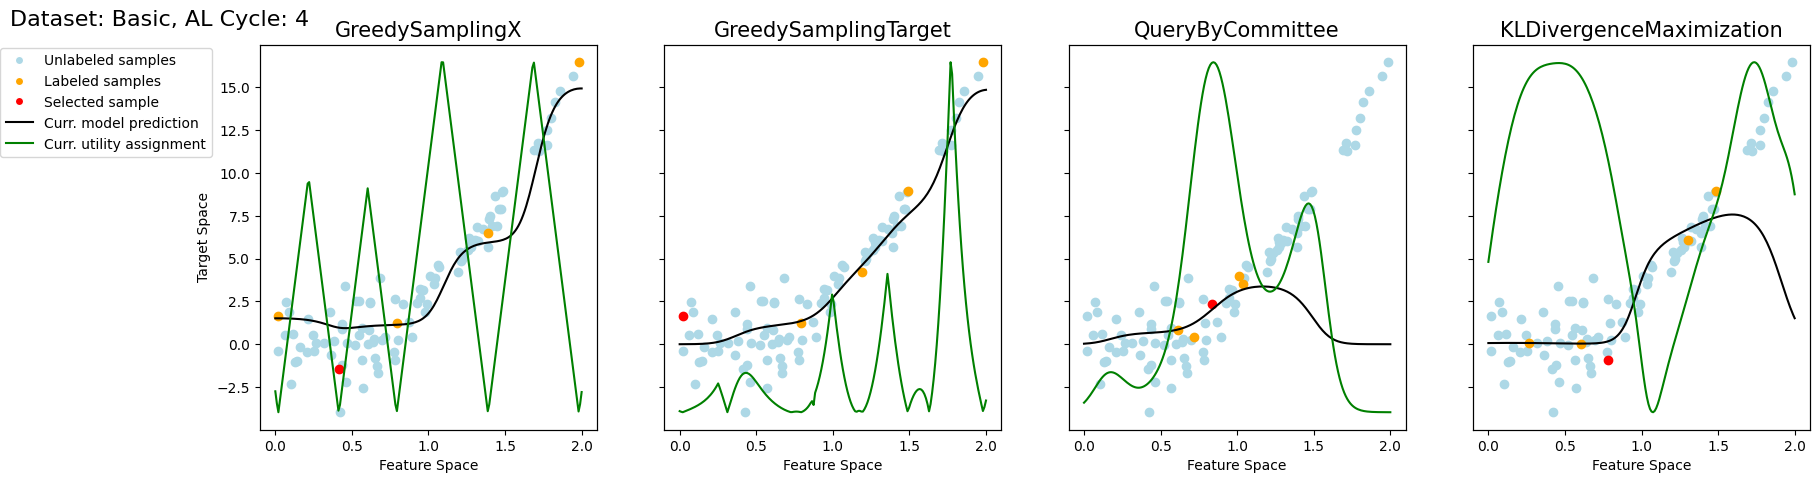

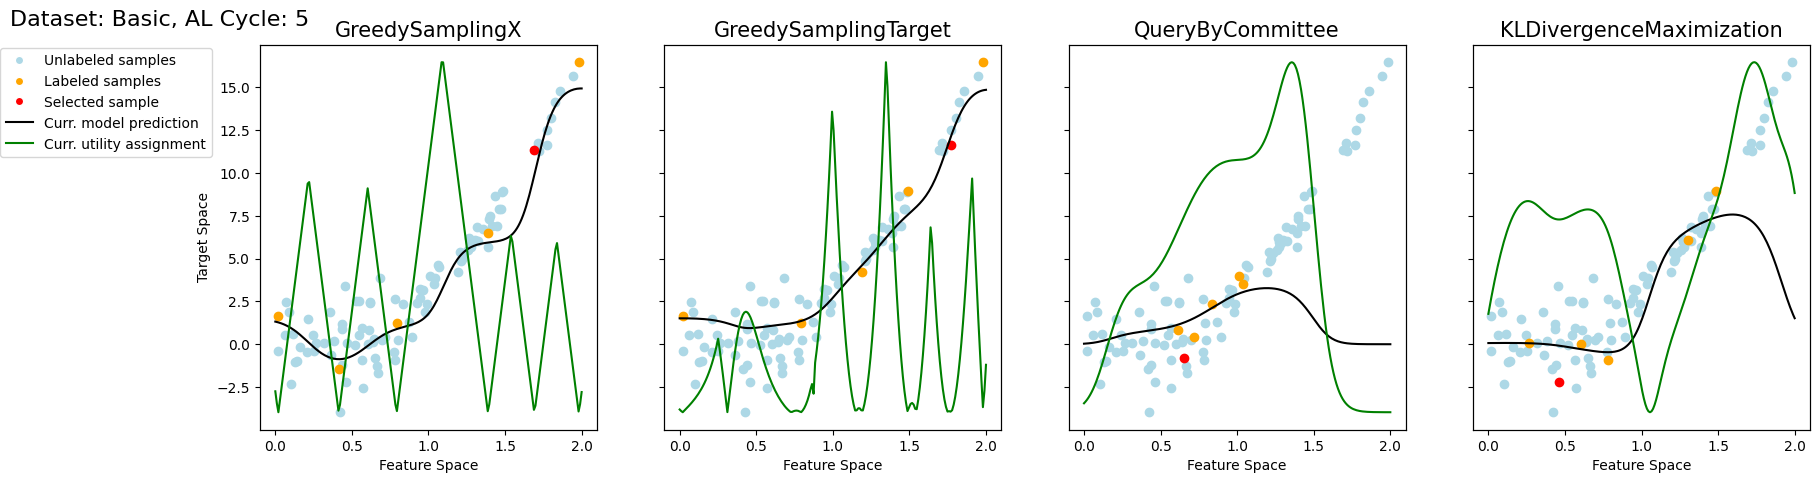

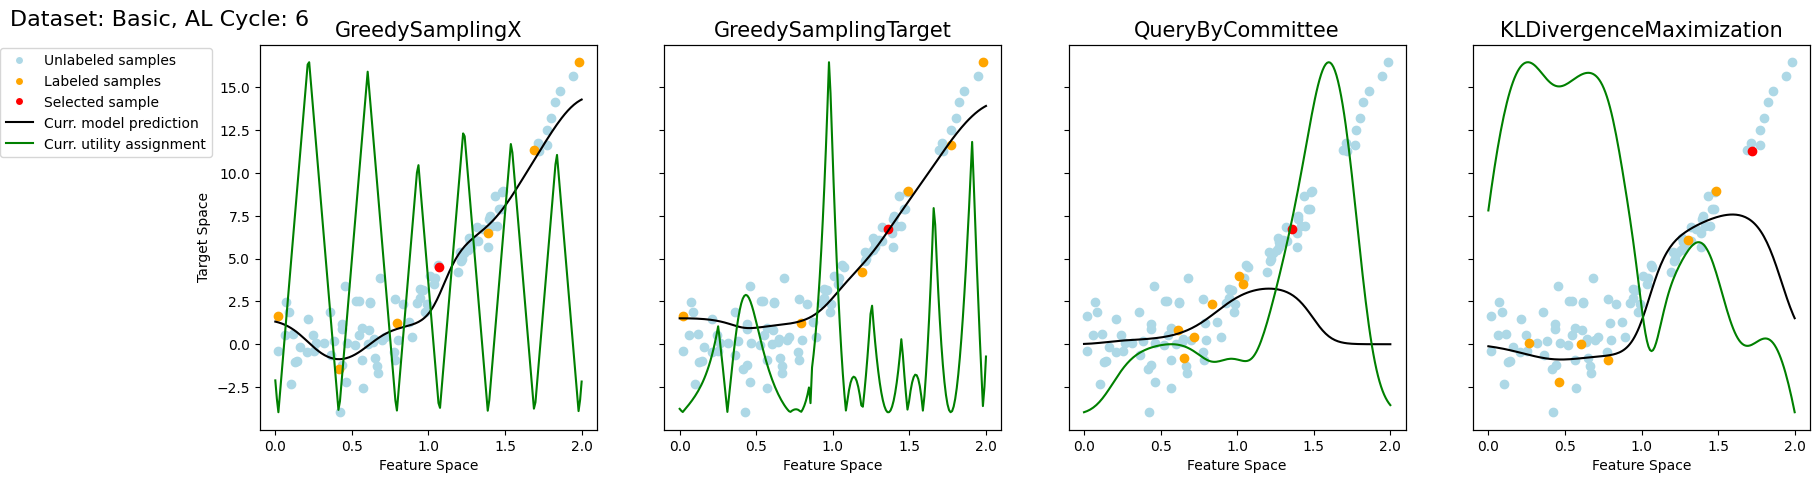

In [ ]:
setting_name = 'Basic' #  < --- select another data set here

true_function, X, noise = settings[setting_name]
X = X.reshape(-1, 1)
y_true = true_function(X) + noise
X_test = np.linspace(0, 2, num=200).reshape(-1, 1)

qs_s = [
    GreedySamplingX(random_state=random_state),
    GreedySamplingTarget(random_state=random_state),
    QueryByCommittee(random_state=random_state),
    KLDivergenceMaximization(
        random_state=random_state,
        # The query strategy relies on approximating different integrals.
        # Here we approximate the integrals assuming the function is linear and the distribution Gaussian.
        integration_dict_target_val={
            "method": "assume_linear",
        },
        integration_dict_cross_entropy={
            "method": "assume_linear",
        }
    ),
]
# Initialize all labels to be missing
y = np.full_like(y_true, MISSING_LABEL)
# Create different label set for all query strategies
y_s = [y.copy() for _ in range(len(qs_s))]

reg = NICKernelRegressor(metric_dict={'gamma': 15.0})

for i in range(n_iterations):
    fig, axes = plt.subplots(1, len(qs_s), figsize=(20, 5), sharey=True)
    axes = [axes, ] if len(qs_s)==1 else axes

    for j, (qs, ax, y) in enumerate(zip(qs_s, axes, y_s)):
        # Start of Actual Active Learning Cycle
        reg.fit(X, y)
        # The function call_func allows us to use the same syntax for all query strategies
        indices, utils = call_func(qs.query,
            X=X,
            y=y,
            reg=reg,
            ensemble=SklearnRegressor(BaggingRegressor(reg, n_estimators=4)),
            fit_reg=True,
            return_utilities=True,
        )
        # store previously labeled samples for visualization
        old_is_lbld = is_labeled(y)
        y[indices] = y_true[indices]
        # End of Actual Active Learning Cycle
        # Start of Visualization
        _, utilities_test = call_func(qs.query,
            X=X,
            y=y,
            reg=reg,
            ensemble=SklearnRegressor(BaggingRegressor(reg, n_estimators=4)),
            candidates=X_test,
            fit_reg=True,
            return_utilities=True,
        )
        is_lbld = is_labeled(y)
        ax_t = ax.twinx()
        ax_t.set_yticks([])
        ax_t.plot(X_test, utilities_test.flatten(), color='green')

        ax.scatter(X[~is_lbld], y_true[~is_lbld], c='lightblue')
        ax.scatter(X[old_is_lbld], y[old_is_lbld], c='orange')
        ax.scatter(X[indices], y[indices], c='red')
        ax.set_xlabel("Feature Space")

        y_pred = reg.predict(X_test)
        ax.plot(X_test, y_pred, c='black')
        ax.set_title(qs.__class__.__name__, fontdict={'fontsize': 15})
    axes[0].set_ylabel("Target Space")
    fig.suptitle(f"Dataset: {setting_name}, AL Cycle: {i}", fontsize=16, x=0, y=.95, horizontalalignment='left', verticalalignment='top')
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',markerfacecolor='lightblue', label='Unlabeled samples'),
        Line2D([0], [0], marker='o', color='w',markerfacecolor='orange', label='Labeled samples'),
        Line2D([0], [0], marker='o', color='w',markerfacecolor='red', label='Selected sample'),
        Line2D([0], [0], color='black',label='Curr. model prediction'),
        Line2D([0], [0], color='green',label='Curr. utility assignment'),
    ]
    fig.legend(handles=legend_elements, loc=(0, 0.675))

    plt.show()